In [38]:
# Definindo alguns processos e seus Burst Times

from process import Process

process_list = [
    Process(1, 8),
    Process(2, 2),
    Process(3, 7),
    Process(4, 3),
    Process(5, 5),
]

In [39]:
# Acionando o escalonador e montando o dataset com os valores gerados

import pandas as pd
from scheduler import *

scheduler(process_list)

data = {
    "Process": list(map(str, cpu_scheduling)),
    "Start": scheduling_starts,
    "End": scheduling_ends,
}

df = pd.DataFrame(data)

df["Quanta"] = df["End"] - df["Start"]

df

,Process,Start,End,Quanta
0,P1,0,3,3
1,P2,4,6,2
2,P3,7,10,3
3,P4,11,14,3
4,P5,15,18,3
...,...,...,...,...
65,P1,19,22,3
66,P3,23,26,3
67,P5,27,29,2
68,P1,30,32,2


<!-- Fluxograma -->

## Fluxograma (Round Robin)

![alt](./flowchart.png)

In [40]:
# Cálculo do uso efetivo da CPU

def cpu_utilization_ratio():
    total_time = scheduling_ends[-1]
    total_bt = 0
    for process in process_list:
        total_bt += process.initial_burst_time
    return total_bt/total_time

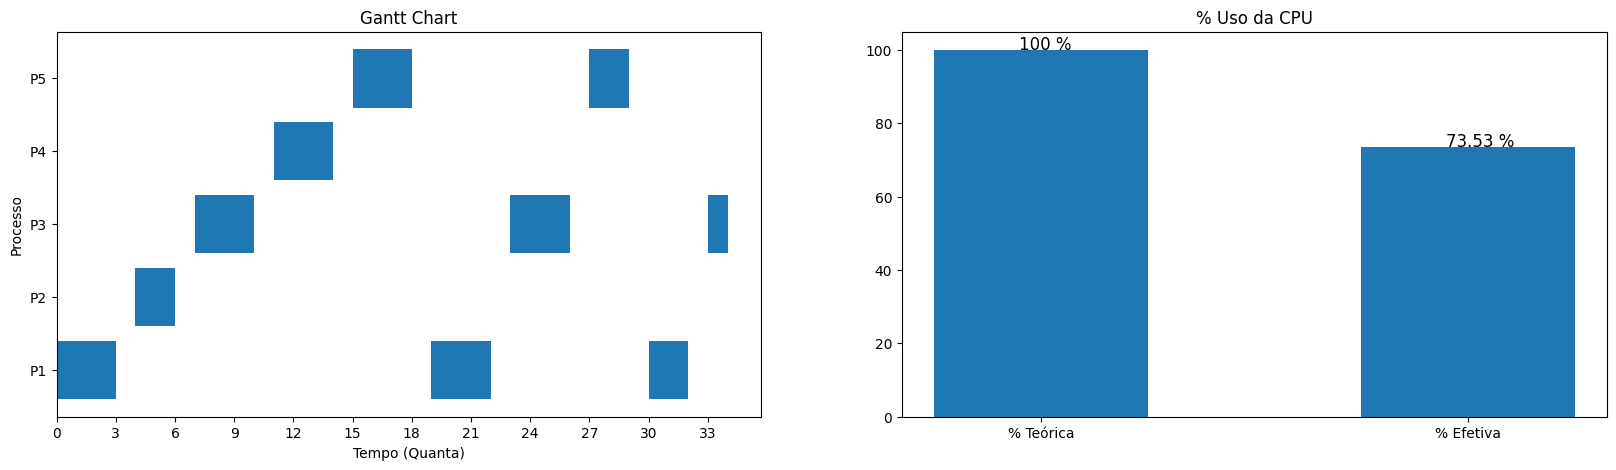

In [41]:
# Plot do Gráfico de Escalonamento em um Gantt Chart

import matplotlib.pyplot as plt

plt.style.use("fast")

# Figura "Pai"
figure = plt.figure(figsize=(20,5))

# Figura "Filha" 1 
figure.add_subplot(1, 2, 1)
plt.title("Gantt Chart")
plt.xlabel("Tempo (Quanta)")
plt.ylabel("Processo")
plt.xticks(range(0, scheduling_ends[-1], 3))
plt.barh(y=df["Process"], left=df["Start"], width=df["Quanta"])

# Figura "Filha" 2
effective_ratio = round(cpu_utilization_ratio()*100, 2)

figure.add_subplot(1, 2, 2)
labels = ["% Teórica", "% Efetiva"]
vals = [100, effective_ratio]
plt.bar(labels, vals, width=0.5)
plt.title("% Uso da CPU")

for idx, val in enumerate(vals):
    txt = f'{val} %'
    x_coord = idx - 0.05
    y_coord = val + 0.30
    
    plt.text(x=x_coord, y=y_coord, s=txt, fontsize=12)

plt.show()

In [42]:
# Cálculo dos Tempos Médios

n = len(process_list)

def avg_waiting_time():
    total_wt = 0
    for process in process_list:
        total_wt += process.waiting_time
    return total_wt/n


def avg_return_time():
    total_rt = 0
    for process in process_list:
        total_rt += process.return_time
    return total_rt/n

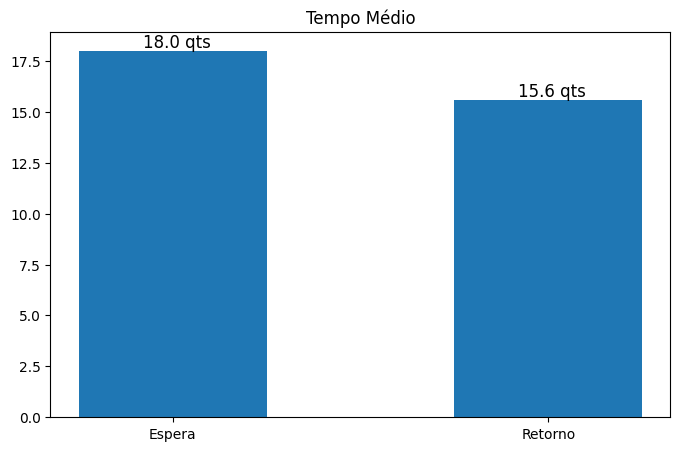

In [43]:
# Plot do Gráfico de Tempos Médios

labels = ["Espera", "Retorno"]
vals = [
    round(avg_waiting_time(), 2),
    round(avg_return_time(), 2)
]

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(labels, vals, width=0.5)

ax.set_title("Tempo Médio")

for idx, val in enumerate(vals):
    txt = f'{val} qts'
    x_coord = idx - 0.08
    y_coord = val + 0.15

    ax.text(x=x_coord, y=y_coord, s=txt, fontsize=12)


Text(0.5, 1.0, 'Vazão ao longo do tempo')

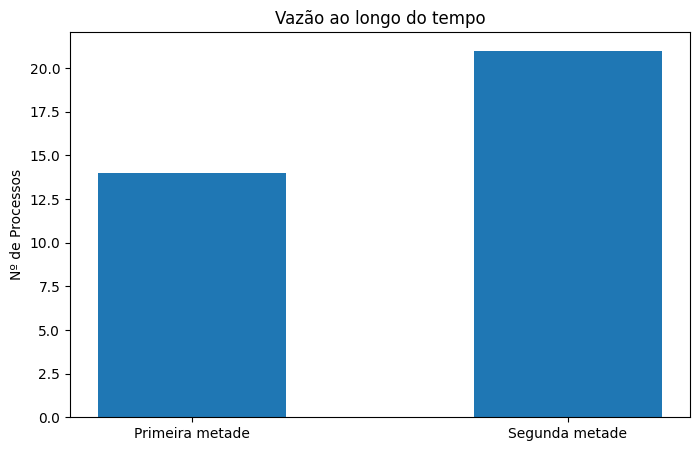

In [44]:
# Plot do Gráfico da Vazão

labels = ["Primeira metade", "Segunda metade"]
vals = [
    len(throughput()[0]),
    len(throughput()[1])
]

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(labels, vals, width=0.5)
ax.set_ylabel("Nº de Processos")

ax.set_title("Vazão ao longo do tempo")